In [1]:
import re
import numpy as np
import pandas as pd
import os
import math
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import sklearn
import matplotlib.pyplot as plt
import scipy.stats as stats
import importlib
import pickle
import time
import bisect
import collections

from keras.layers import Conv1D, GlobalMaxPool1D, Dense, Flatten, LSTM, CuDNNLSTM, Bidirectional, RepeatVector, MaxPooling1D, Dropout, Input, TimeDistributed, concatenate
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import regularizers


import lstm_ui_def_mult_train
import lstm_ui_tools_mult_train

/opt/anaconda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(lstm_ui_tools_mult_train)
importlib.reload(lstm_ui_def_mult_train)

<module 'lstm_ui_def_mult_train' from '/opt/LMCO/git/notebooks/DS/mh/Siat_work/gps3/LSTM_GPSIII/lstm_ui_def_mult_train.py'>

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.2.


# Finding categorical sensors and sensors to omit

In [4]:
directory = '/NEC/DATA/ATLO/GPSIII/Processed_ENG'
omit = ['RAW']
# omit = ['CMDTRQ', 'CURR', 'RATBIAS', '_M', 'RATCMD', 'RATERR', 'RAW', 'TQDMD', 'CMDTRQ', 'BMOM', 'RWABTRQ' ]
df = pd.read_csv(os.path.join(directory,'GPS3_SV02_small_h1.csv'))
omit_sensors = []
for sens in df.columns:
    cat = False
    for subword in omit:
        cat = cat or subword in sens
    if cat:
        omit_sensors.append(sens)
print(len(omit_sensors))
print(omit_sensors)

8
['RWA1_RAW1', 'RWA1_RAW2', 'RWA2_RAW1', 'RWA2_RAW2', 'RWA3_RAW1', 'RWA3_RAW2', 'RWA4_RAW1', 'RWA4_RAW2']


In [5]:
directory = '/NEC/DATA/ATLO/GPSIII/Processed_ENG'
catsubs = ['CMDTRQ', 'CURR', 'RATBIAS', '_M', 'RATCMD', 'RATERR', 'TQDMD', 'CMDTRQ', 'BMOM', 'RWABTRQ' ]
df = pd.read_csv(os.path.join(directory,'GPS3_SV02_small_h1.csv'))
cat_sensors = []
for sens in df.columns:
    cat = False
    for subword in catsubs:
        cat = cat or subword in sens
    if cat:
        cat_sensors.append(sens)
print(len(cat_sensors))
print(cat_sensors)

37
['RWA1_CMDTRQ', 'RWA1_CMDTRQ_M', 'RWA1_CURR', 'RWA1_RATBIAS', 'RWA1_RATCMD', 'RWA1_RATERR', 'RWA1_TQDMD', 'RWA2_CMDTRQ', 'RWA2_CMDTRQ_M', 'RWA2_CURR', 'RWA2_RATBIAS', 'RWA2_RATCMD', 'RWA2_RATERR', 'RWA2_TQDMD', 'RWA3_CMDTRQ', 'RWA3_CMDTRQ_M', 'RWA3_CURR', 'RWA3_RATBIAS', 'RWA3_RATCMD', 'RWA3_RATERR', 'RWA3_TQDMD', 'RWA4_CMDTRQ', 'RWA4_CMDTRQ_M', 'RWA4_CURR', 'RWA4_RATBIAS', 'RWA4_RATCMD', 'RWA4_RATERR', 'RWA4_TQDMD', 'RWABMOM_1', 'RWABMOM_2', 'RWABMOM_3', 'RWABTRQDMD_1', 'RWABTRQDMD_2', 'RWABTRQDMD_3', 'RWABTRQLIM_1', 'RWABTRQLIM_2', 'RWABTRQLIM_3']


In [6]:
trainfiles = directory+'/GPS3_SV02_small_h1.csv, '+directory+'/GPS3_SV02_small_c1.csv, '+directory+'/GPS3_SV02_small_h4.csv, '+directory+'/GPS3_SV02_small_c4.csv'

In [7]:
trainfiles

'/NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_h1.csv, /NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_c1.csv, /NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_h4.csv, /NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_c4.csv'

In [8]:
[x.strip() for x in trainfiles.split(',')]

['/NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_h1.csv',
 '/NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_c1.csv',
 '/NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_h4.csv',
 '/NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_c4.csv']

/NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_h1.csv
/NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_c1.csv
/NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_h4.csv
/NEC/DATA/ATLO/GPSIII/Processed_ENG/GPS3_SV02_small_c4.csv
0      0.647481
1     -0.840653
2      0.621087
3     -0.814266
4     -0.002235
         ...   
217    0.000000
218    0.000000
219    0.000000
220    0.000000
221    0.000000
Name: 0, Length: 222, dtype: float64
0     -0.993364
1     -0.840653
2     -0.992624
3     -0.814266
4     -0.002235
         ...   
217    0.000000
218    0.000000
219    0.000000
220    0.000000
221    0.000000
Name: 0, Length: 222, dtype: float64
0      0.572897
1     -0.840653
2      0.544243
3     -0.814266
4     -0.002235
         ...   
217    0.000000
218    0.000000
219    0.000000
220    0.000000
221    0.000000
Name: 0, Length: 222, dtype: float64
0     -1.291699
1     -0.840653
2     -1.299998
3     -0.814266
4     -0.002235
         ...   
217    0.000000
218    0.0000

Full epoch val_loss = 0.03623077681449314
Full Epoch 7
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0408 - val_loss: 0.0294
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0358 - val_loss: 0.0287
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0378 - val_loss: 0.0288
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0344 - val_loss: 0.0284
Full epoch val_loss = 0.028799812311831957
Full Epoch 8
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0401 - val_loss: 0.0282
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0360 - val_loss: 0.0272
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0365 - val_loss: 0.0264
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0335 - val_loss: 0.0250
Full epoch val_loss = 0.026677731775607054
Full Epoch 9
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0339 - val_

1/1 [==============================] - 1s 1s/step - loss: 0.0171 - val_loss: 0.0164
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0219 - val_loss: 0.0163
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0186 - val_loss: 0.0162
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0195 - val_loss: 0.0160
Full epoch val_loss = 0.016226392666766724
Full Epoch 19
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0207 - val_loss: 0.0159
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0210 - val_loss: 0.0156
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0172 - val_loss: 0.0155
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0213 - val_loss: 0.0155
Full epoch val_loss = 0.015614094307406609
Full Epoch 20
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0167 - val_loss: 0.0155
Epoch 1/1
1/1 [==============================] - 1

1/1 [==============================] - 1s 1s/step - loss: 0.0165 - val_loss: 0.0130
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0155 - val_loss: 0.0129
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0155 - val_loss: 0.0130
Full epoch val_loss = 0.01305374886772673
Full Epoch 30
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0127 - val_loss: 0.0130
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0166 - val_loss: 0.0130
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0137 - val_loss: 0.0131
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0157 - val_loss: 0.0133
Full epoch val_loss = 0.013135832045279525
Full Epoch 31
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0144 - val_loss: 0.0135
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0164 - val_loss: 0.0132
Epoch 1/1
1/1 [==============================] - 1s

1/1 [==============================] - 1s 1s/step - loss: 0.0119 - val_loss: 0.0118
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0118 - val_loss: 0.0116
Full epoch val_loss = 0.011903213731551288
Full Epoch 41
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0116 - val_loss: 0.0115
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0127 - val_loss: 0.0116
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0112 - val_loss: 0.0116
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0134 - val_loss: 0.0118
Full epoch val_loss = 0.011640133512339208
Full Epoch 42
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0104 - val_loss: 0.0121
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0131 - val_loss: 0.0120
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0114 - val_loss: 0.0120
Epoch 1/1
1/1 [==============================] - 1

1/1 [==============================] - 1s 1s/step - loss: 0.0111 - val_loss: 0.0108
Full epoch val_loss = 0.010730628814370646
Full Epoch 52
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0097 - val_loss: 0.0112
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0121 - val_loss: 0.0113
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0096 - val_loss: 0.0114
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0103 - val_loss: 0.0113
Full epoch val_loss = 0.011271904756983694
Full Epoch 53
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0095 - val_loss: 0.0112
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0100 - val_loss: 0.0107
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0103 - val_loss: 0.0106
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0106 - val_loss: 0.0107
Full epoch val_loss = 0.010793476724136735
Full Ep

1/1 [==============================] - 1s 1s/step - loss: 0.0082 - val_loss: 0.0104
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0107 - val_loss: 0.0101
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0087 - val_loss: 0.0100
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.0083 - val_loss: 0.0102
Full epoch val_loss = 0.010165840577564011


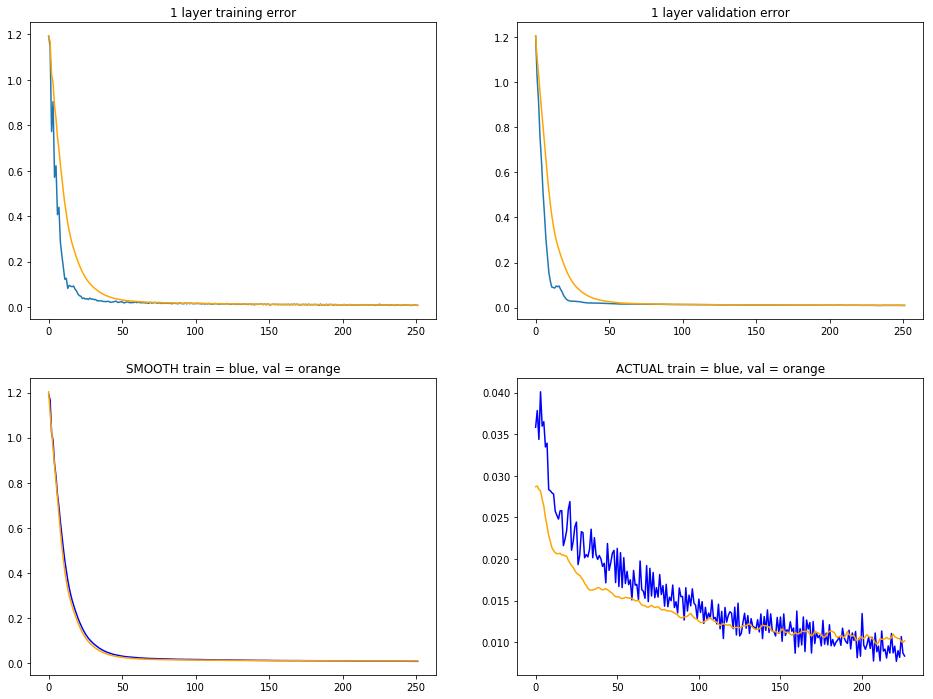

In [35]:
directory = '/NEC/DATA/ATLO/GPSIII/Processed_ENG'
importlib.reload(lstm_ui_tools_mult_train)
importlib.reload(lstm_ui_def_mult_train)
model2 = lstm_ui_tools_mult_train.train_model(trainfile = trainfiles,
            testfile = directory+'/GPS3_SV01_small_c4.csv',
           cat_sensors = cat_sensors,
           omit_sensors = omit_sensors,
           fullepochs = 5000,
           verbose = True,
           patience = 4,
           graph_training_curves=True)



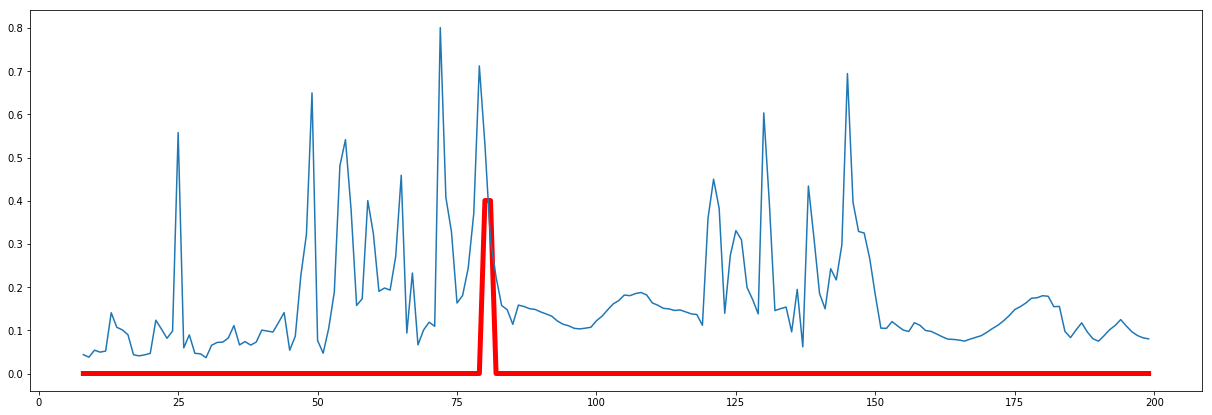

[80, 81]
RWA3_RATE       0.056932
RWA3_PLS_CNT    0.041137
RWA1_RATE       0.010547
RWA2_TMP        0.010330
RWA3_TMP        0.000471
RWA1_PLS_CNT   -0.004691
RWA1_TMP       -0.017434
RWA4_TMP       -0.019280
RWA4_RATE      -0.029602
RWA2_RATE      -0.035688
RWA4_PLS_CNT   -0.040767
RWA2_PLS_CNT   -0.040781
dtype: float64


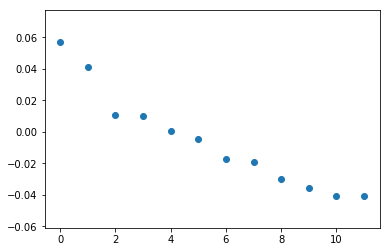

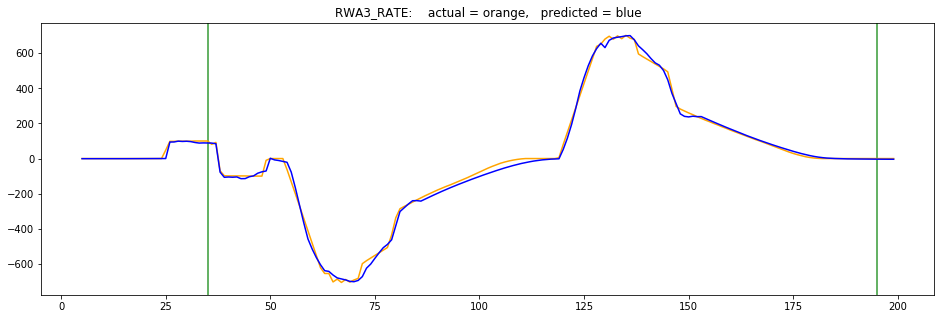

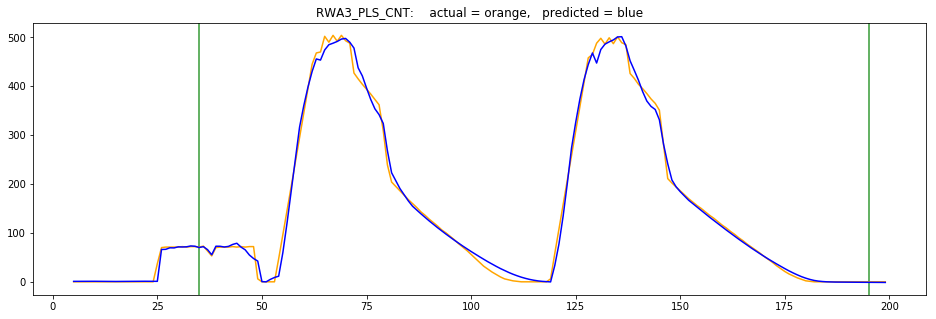

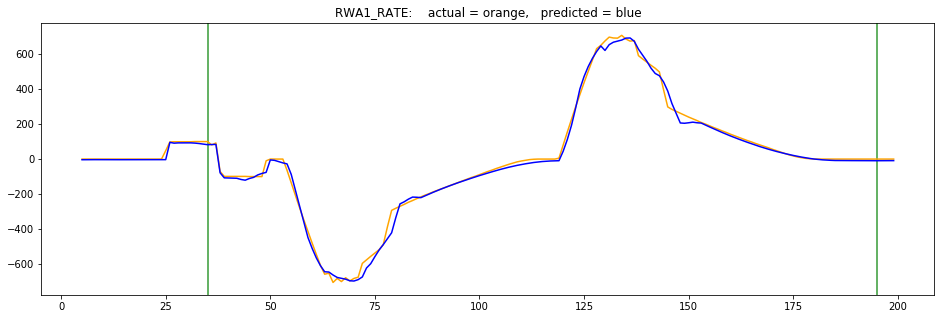

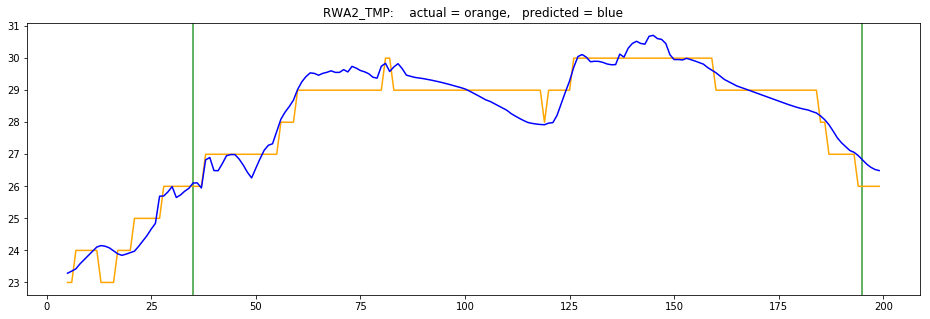

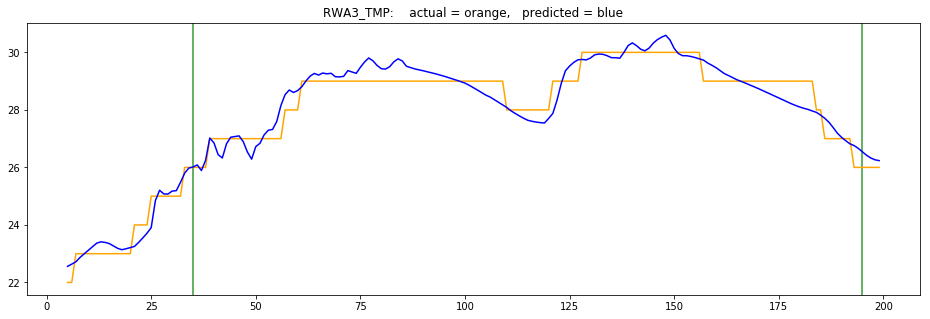

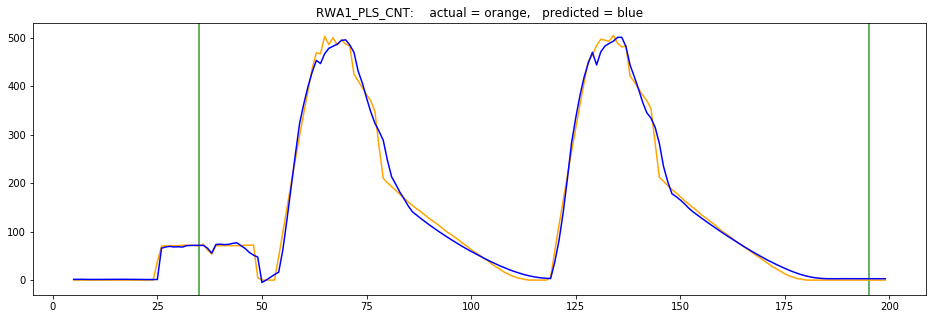

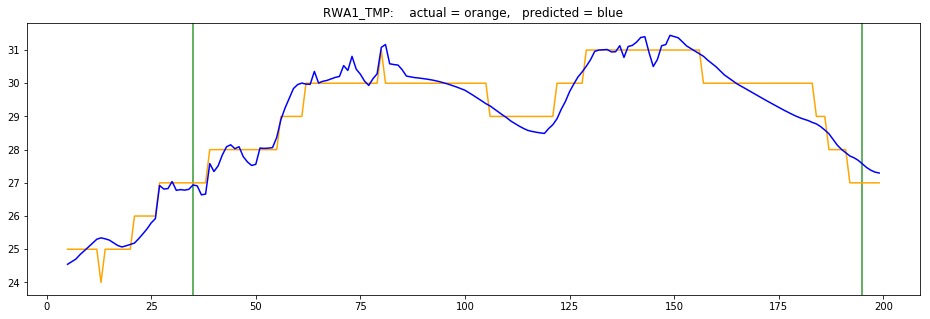

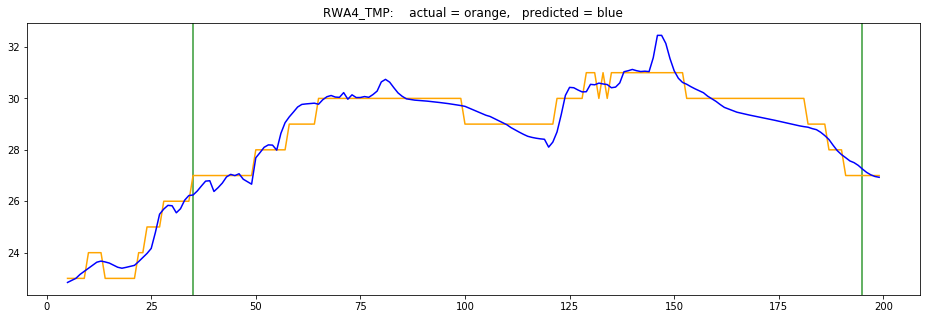

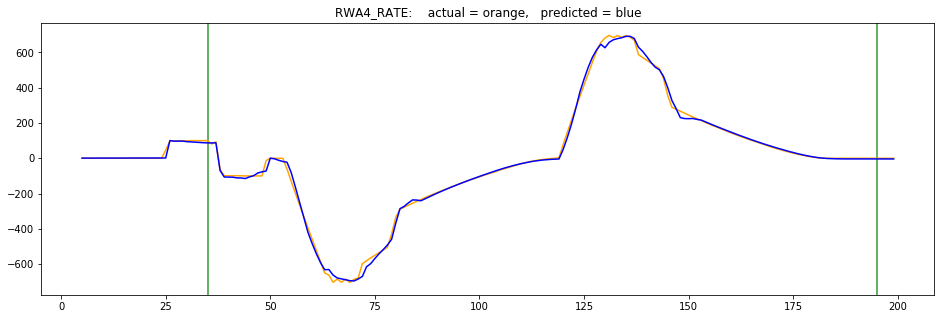

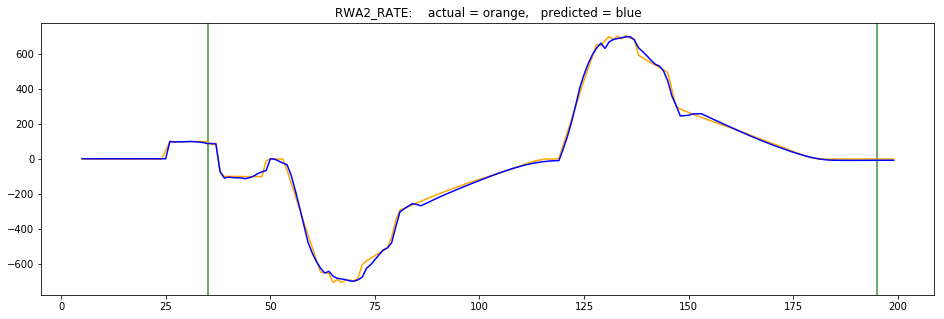

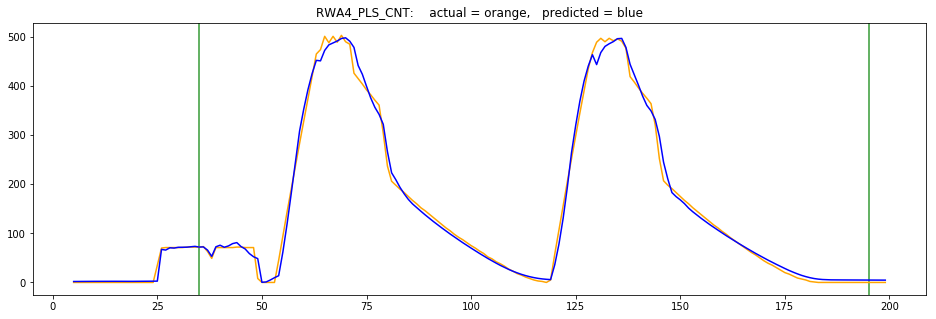

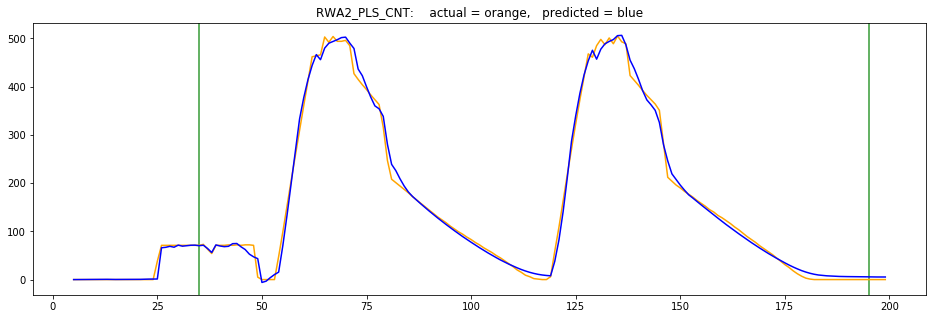

In [60]:
# Just verifying the model against a member of the training set.
importlib.reload(lstm_ui_tools_mult_train)
score, r2score, raw_preds, scaled_preds, raw_flag, flagged_times = lstm_ui_tools_mult_train.score_model_gps3(model2,
                                            inferencefile=directory+'/GPS3_SV02_small_h4.csv',
                                            r2=-np.inf,
                                            graph_score=False,
                                            rolling_window = 3,
                                            graph_flag = True)

print(flagged_times)


mean_diff = lstm_ui_tools_mult_train.find_newly_broken_gps3(model2, 105, 111)
print(mean_diff)
plt.scatter(list(range(len(mean_diff))),mean_diff)
plt.show()


lstm_ui_tools_mult_train.graph_sensors_gps(model2, sensorlist = mean_diff.index.tolist(), anomstart=35, anomend=195)



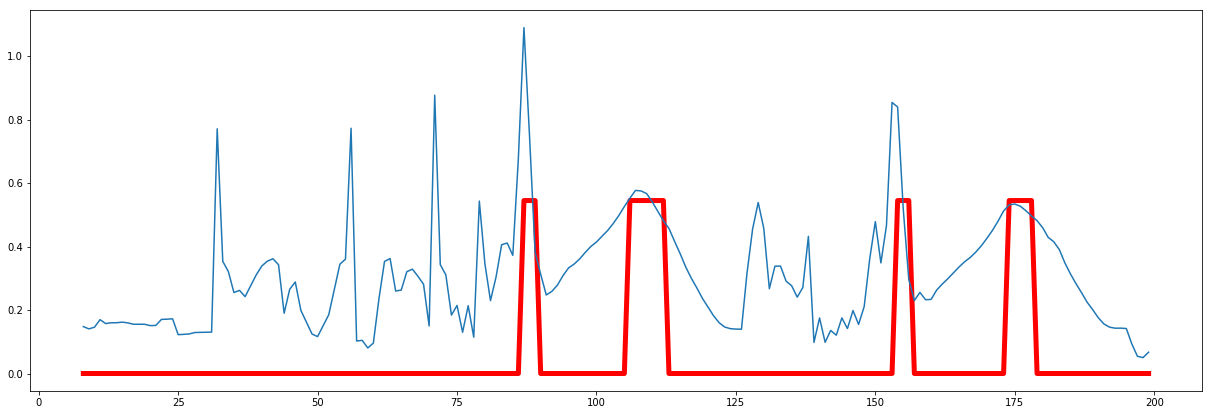

[87, 88, 89, 106, 107, 108, 109, 110, 111, 112, 154, 155, 156, 174, 175, 176, 177, 178]
RWA3_RATE       0.256513
RWA4_PLS_CNT    0.253514
RWA3_PLS_CNT    0.201267
RWA1_PLS_CNT    0.198521
RWA4_RATE       0.085920
RWA2_PLS_CNT    0.082790
RWA4_TMP        0.061047
RWA2_RATE       0.039545
RWA1_RATE       0.020115
RWA1_TMP       -0.005188
RWA2_TMP       -0.017953
RWA3_TMP       -0.020256
dtype: float64


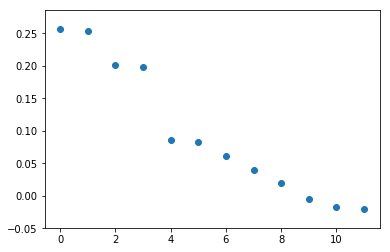

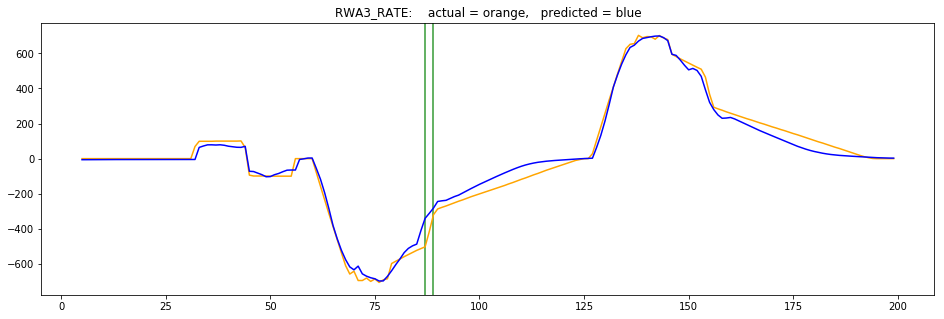

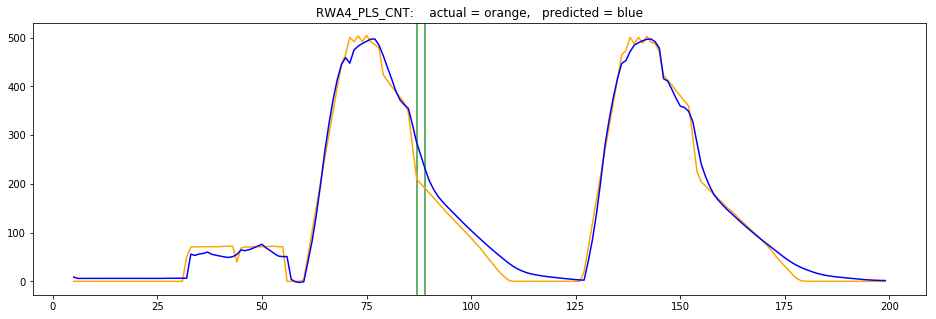

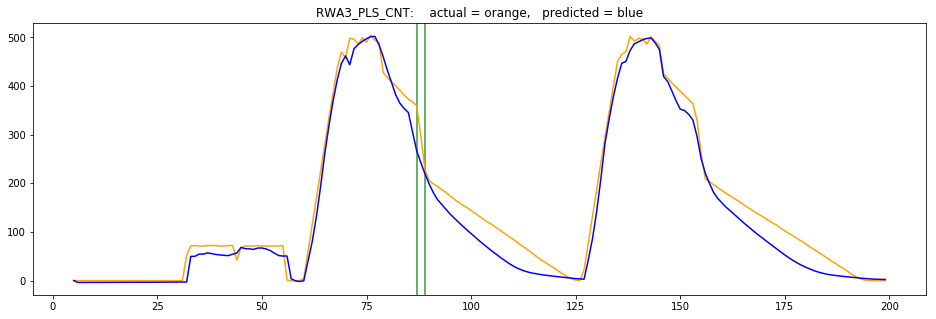

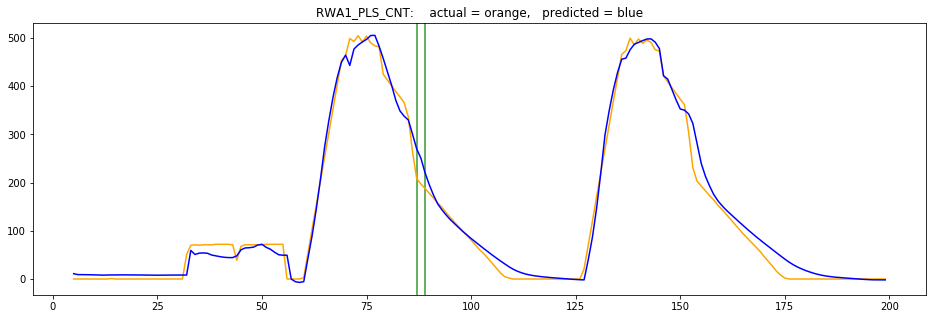

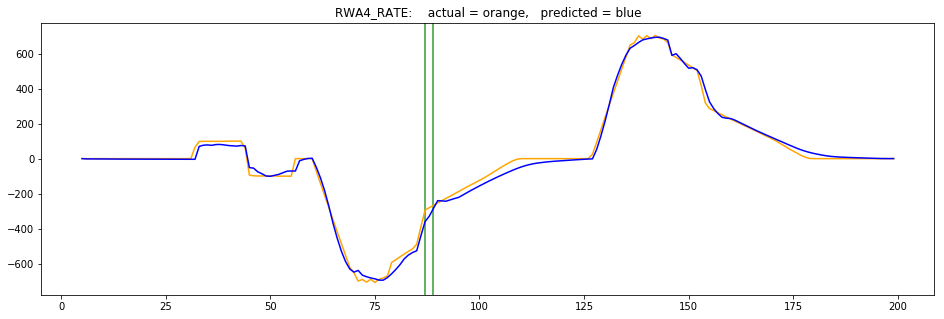

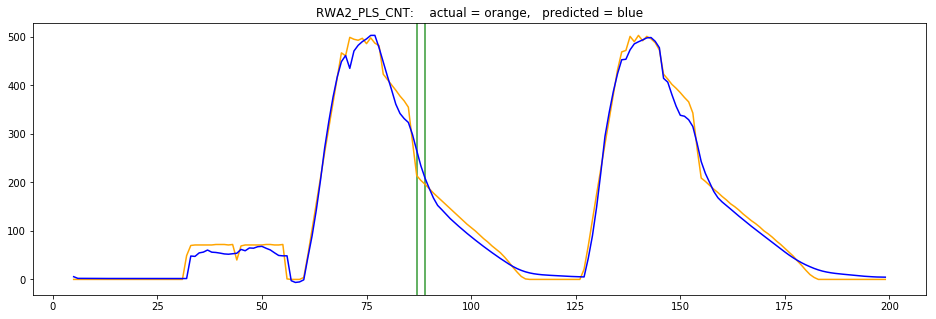

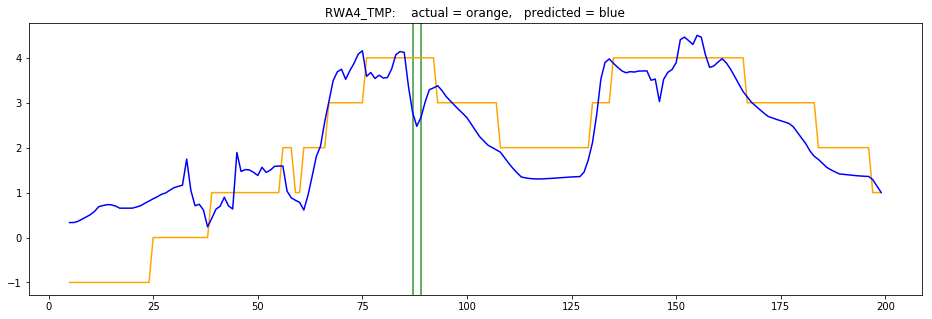

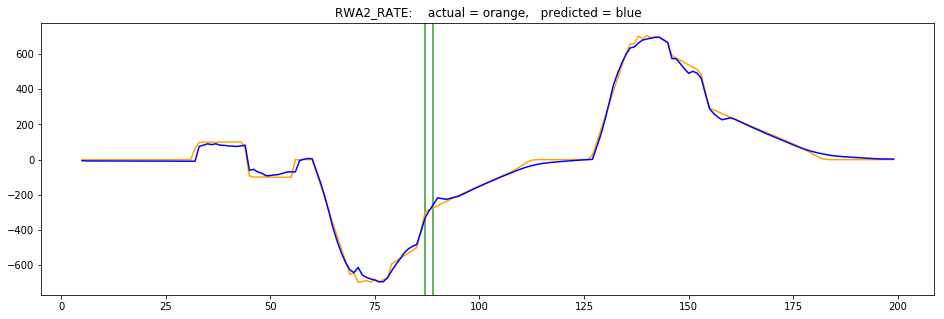

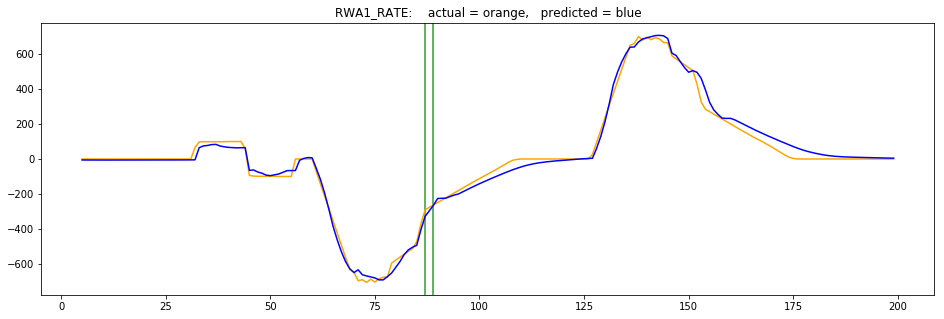

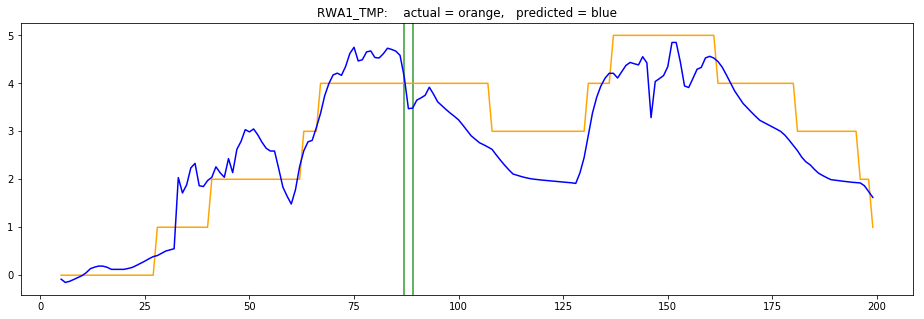

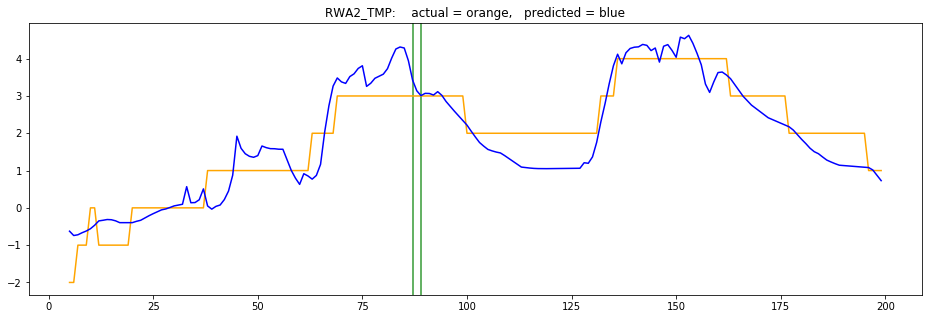

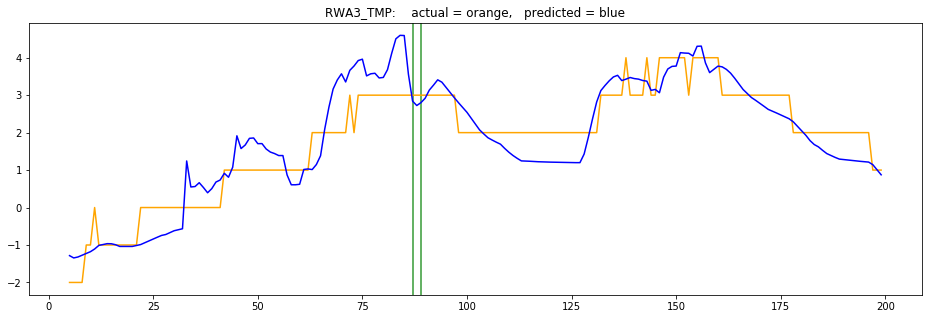

In [65]:
# Does it see the slow wheel in SV1C4?  Yes, during both 87-89 and 106-112 periods.
importlib.reload(lstm_ui_tools_mult_train)
score, r2score, raw_preds, scaled_preds, raw_flag, flagged_times = lstm_ui_tools_mult_train.score_model_gps3(model2,
                                            inferencefile=directory+'/GPS3_SV01_small_c4.csv',
                                            r2=-np.inf,
                                            graph_score=False,
                                            rolling_window = 3,
                                            graph_flag = True)

print(flagged_times)


mean_diff = lstm_ui_tools_mult_train.find_newly_broken_gps3(model2, 87, 89)
print(mean_diff)
plt.scatter(list(range(len(mean_diff))),mean_diff)
plt.show()


lstm_ui_tools_mult_train.graph_sensors_gps(model2, sensorlist = mean_diff.index.tolist(), anomstart=87, anomend=89)



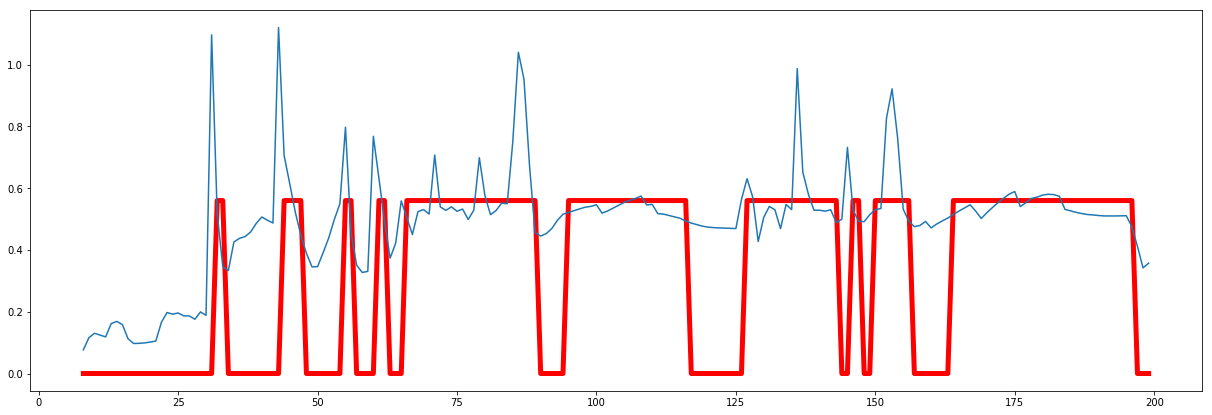

[32, 33, 44, 45, 46, 47, 55, 56, 61, 62, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 146, 147, 150, 151, 152, 153, 154, 155, 156, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196]
RWA1_TMP        0.260161
RWA2_TMP        0.230515
RWA4_TMP        0.195598
RWA3_TMP        0.161052
RWA4_PLS_CNT    0.046242
RWA3_PLS_CNT    0.040583
RWA4_RATE       0.039368
RWA1_PLS_CNT    0.029473
RWA3_RATE       0.020315
RWA1_RATE       0.014563
RWA2_RATE       0.011625
RWA2_PLS_CNT   -0.005353
dtype: float64


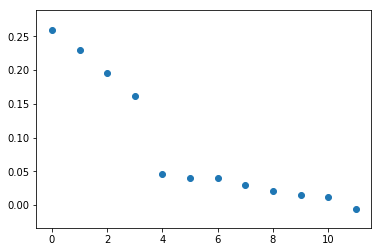

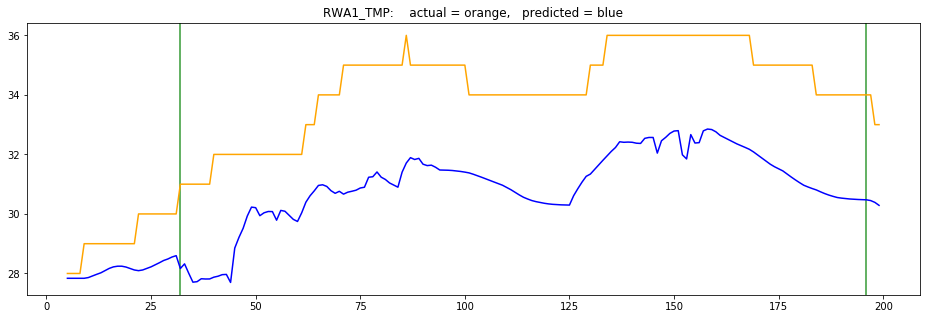

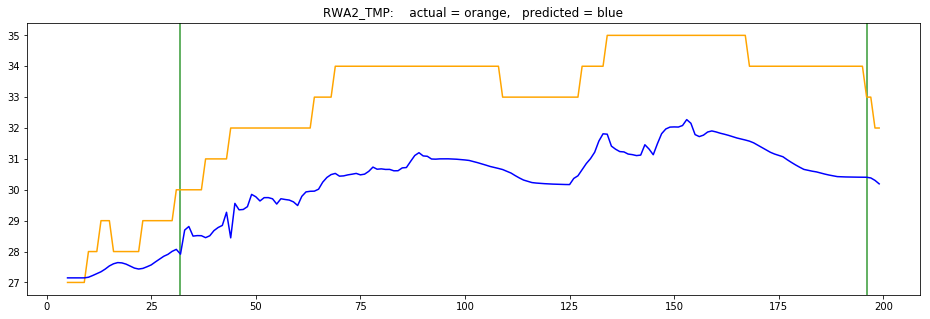

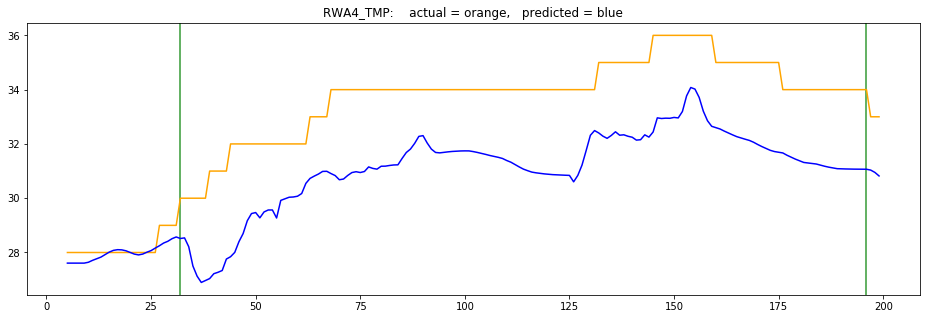

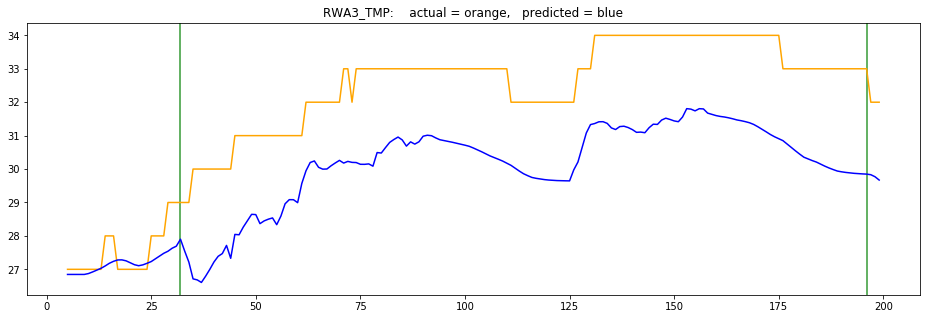

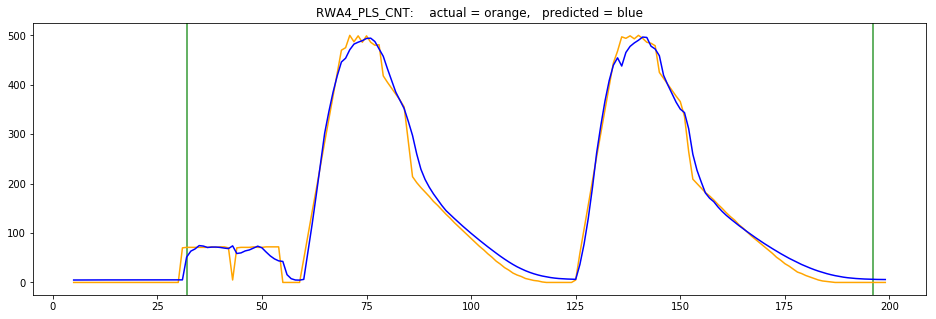

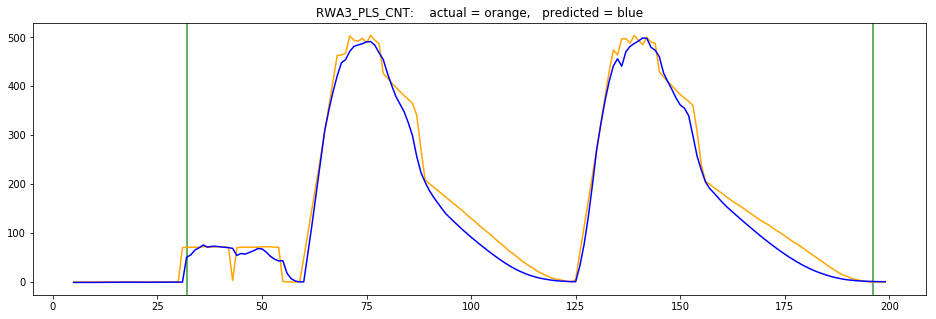

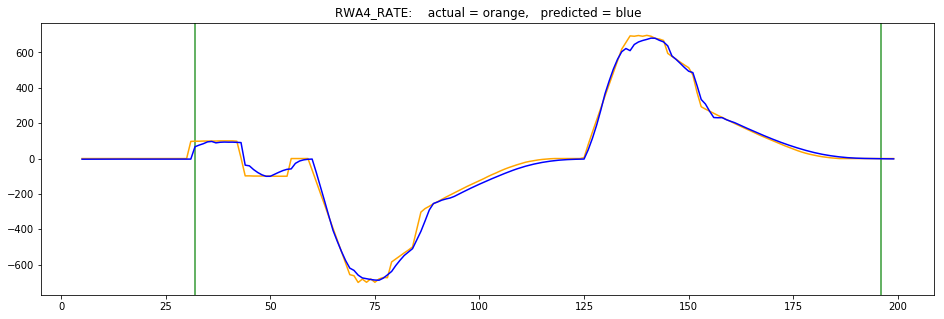

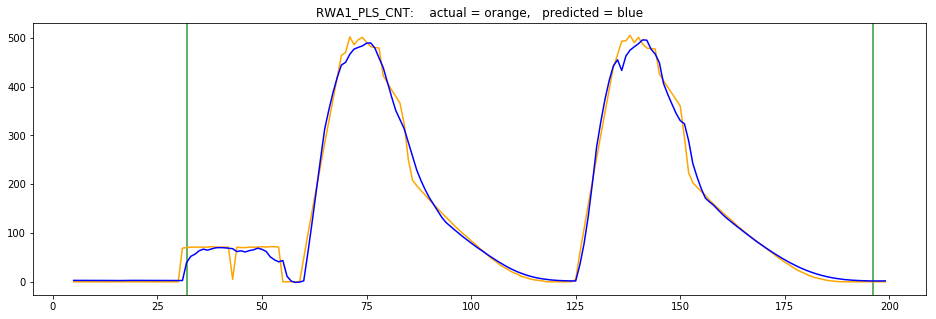

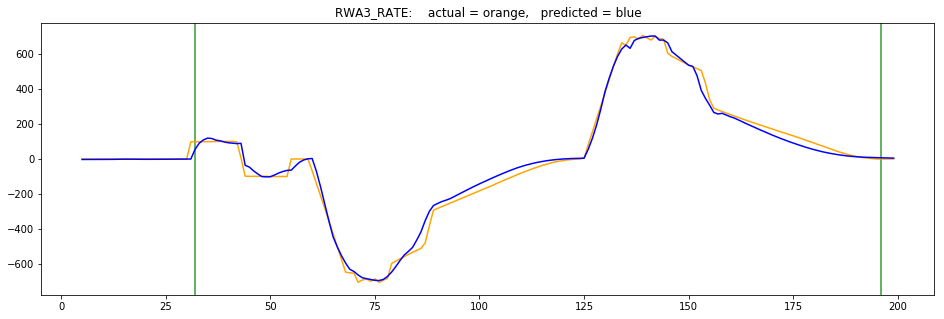

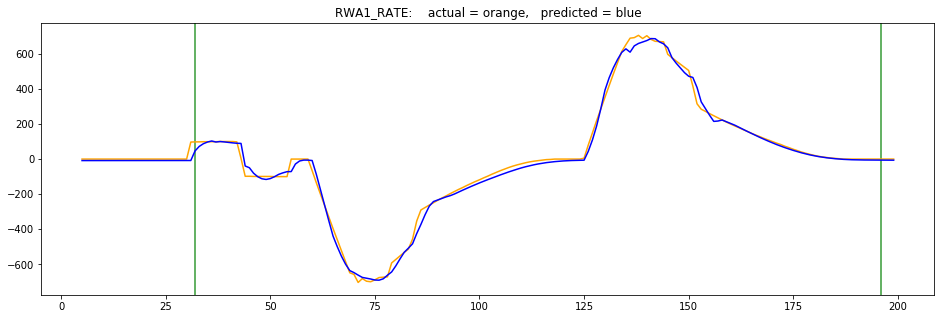

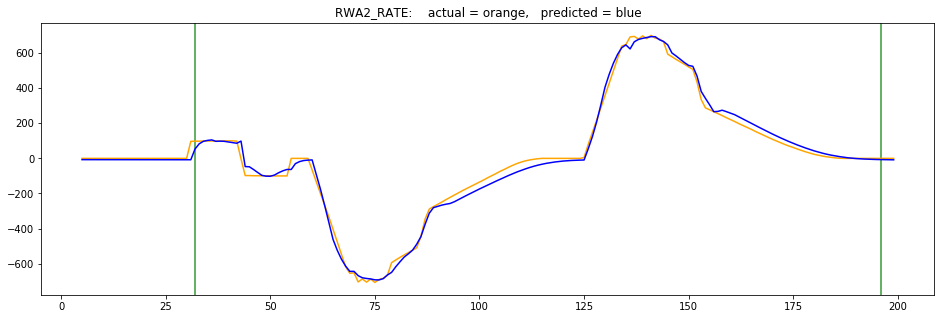

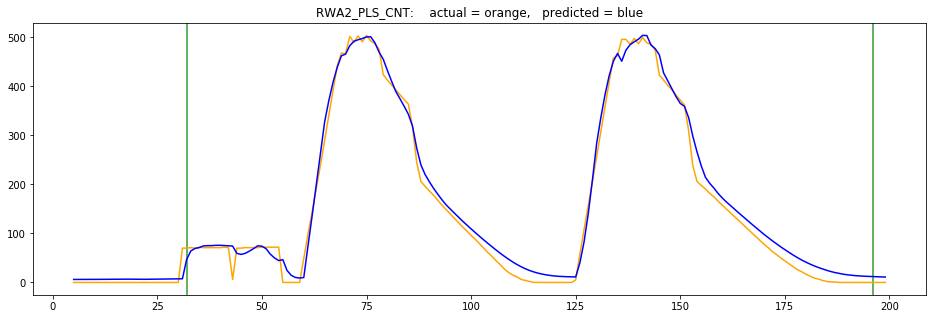

In [123]:
# Does it see the tmp difference in SV1H4? Yes, the whole time.  But it is now blind to the slow wheel.
importlib.reload(lstm_ui_tools_mult_train)
score, r2score, raw_preds, scaled_preds, raw_flag, flagged_times = lstm_ui_tools_mult_train.score_model_gps3(model2,
                                            inferencefile=directory+'/GPS3_SV01_small_h4.csv',
                                            r2=-np.inf,
                                            graph_score=False,
                                            rolling_window = 3,
                                            graph_flag = True)

print(flagged_times)


mean_diff = lstm_ui_tools_mult_train.find_newly_broken_gps3(model2, 69, 79)
print(mean_diff)
plt.scatter(list(range(len(mean_diff))),mean_diff)
plt.show()


lstm_ui_tools_mult_train.graph_sensors_gps(model2, sensorlist = mean_diff.index.tolist(), anomstart=32, anomend=196)



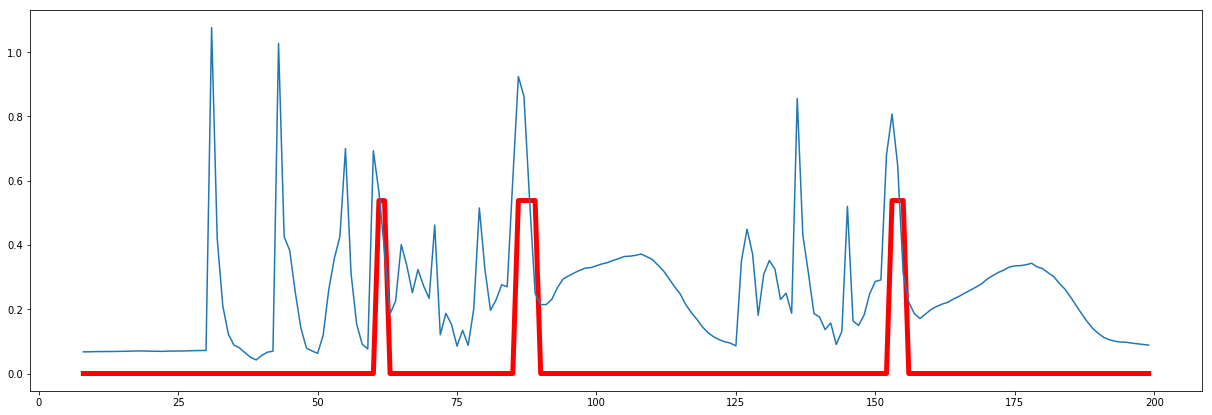

[61, 62, 86, 87, 88, 89, 153, 154, 155]
RWA4_PLS_CNT    0.222771
RWA3_PLS_CNT    0.219292
RWA3_RATE       0.205310
RWA4_RATE       0.101180
RWA1_PLS_CNT    0.088448
RWA2_PLS_CNT    0.069849
RWA1_RATE       0.044673
RWA2_RATE       0.003098
dtype: float64


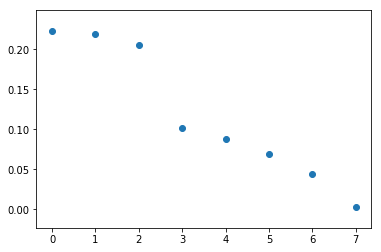

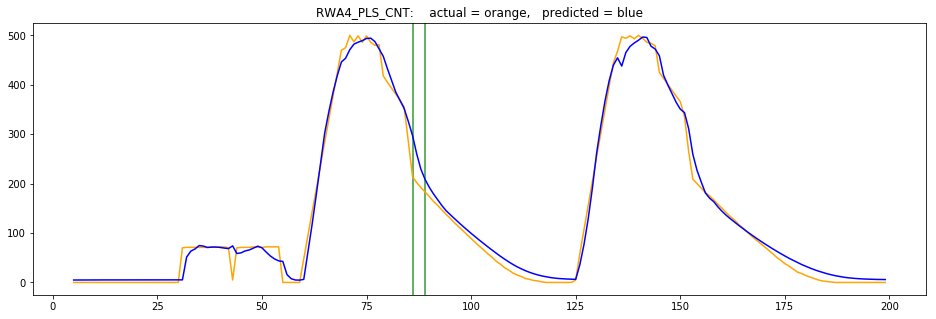

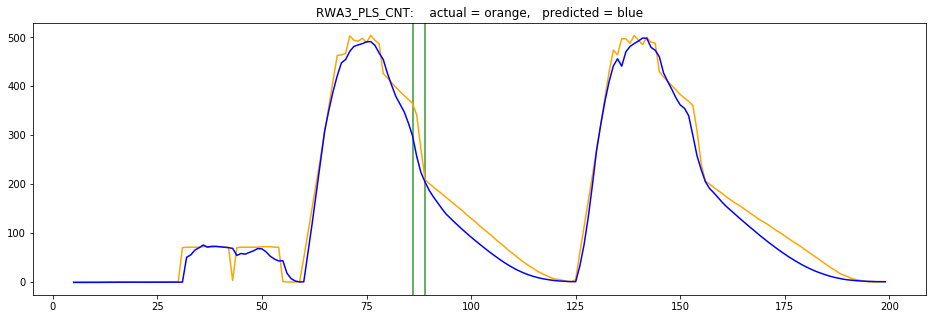

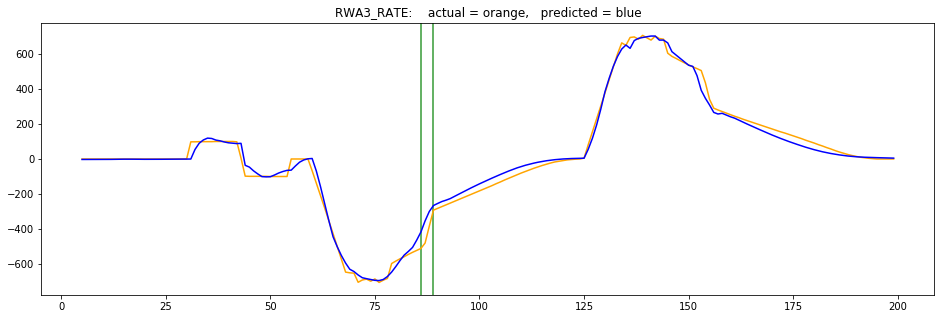

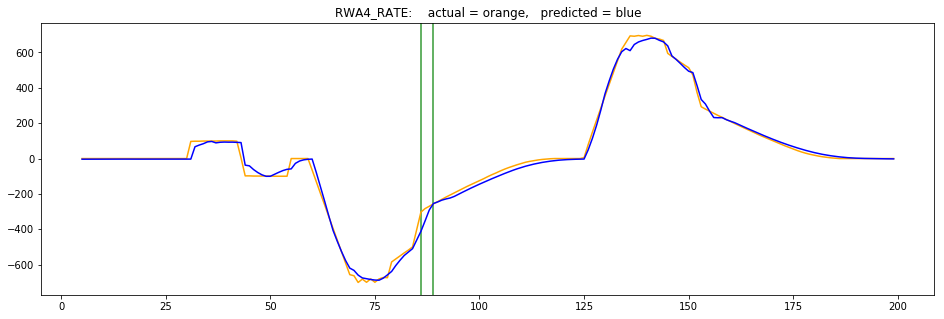

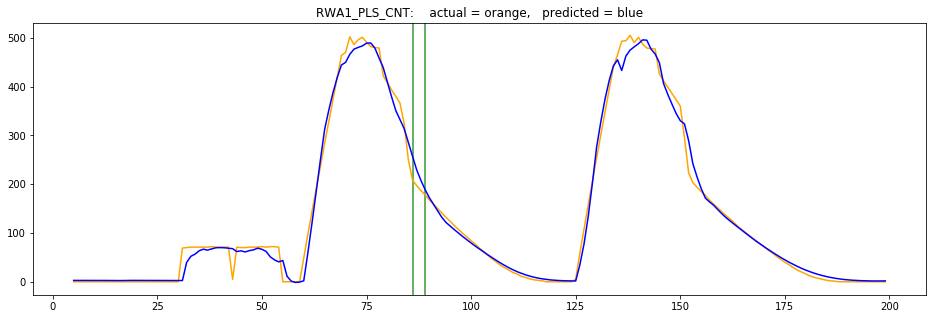

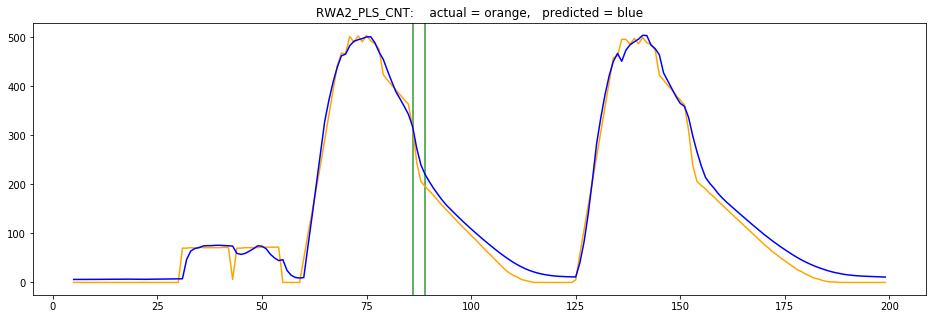

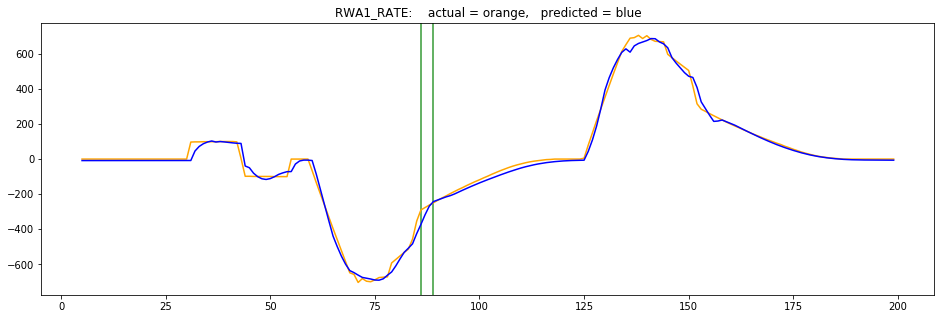

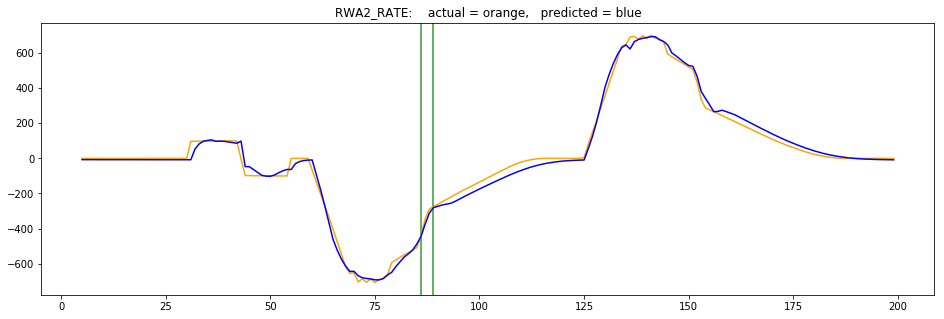

In [70]:
# You can see the slow wheel in SV1H4 by filtering out the stronger-contribution "anomalous" temperature sensors.
importlib.reload(lstm_ui_tools_mult_train)
score, r2score, raw_preds, scaled_preds, raw_flag, flagged_times = lstm_ui_tools_mult_train.score_model_gps3(model2,
                                            inferencefile=directory+'/GPS3_SV01_small_h4.csv',
                                            r2=0.98,
                                            graph_score=False,
                                            rolling_window = 3,
                                            graph_flag = True)

print(flagged_times)


mean_diff = lstm_ui_tools_mult_train.find_newly_broken_gps3(model2, 86, 89)
print(mean_diff)
plt.scatter(list(range(len(mean_diff))),mean_diff)
plt.show()


lstm_ui_tools_mult_train.graph_sensors_gps(model2, sensorlist = mean_diff.index.tolist(), anomstart=86, anomend=89)



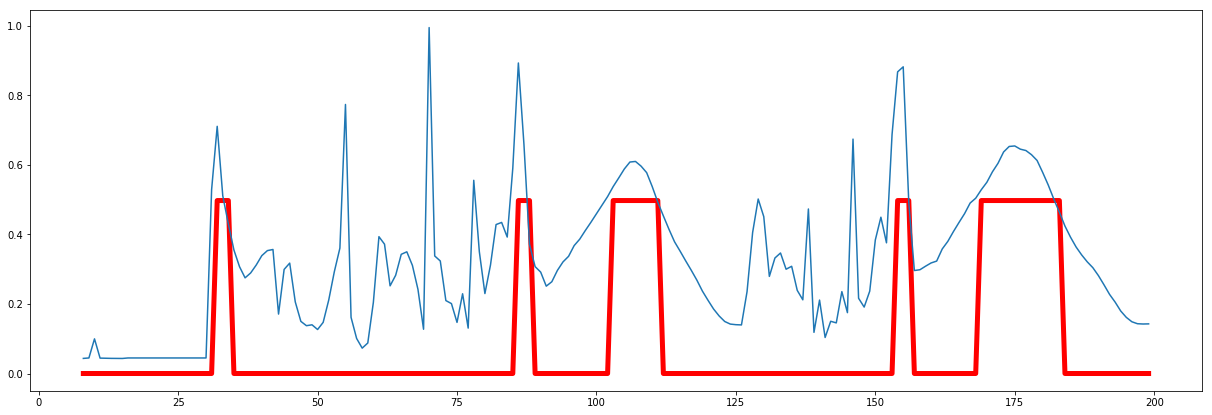

[32, 33, 34, 86, 87, 88, 103, 104, 105, 106, 107, 108, 109, 110, 111, 154, 155, 156, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183]
RWA3_PLS_CNT    0.279170
RWA3_RATE       0.196596
RWA1_RATE       0.134007
RWA4_PLS_CNT    0.114742
RWA4_RATE       0.107270
RWA1_PLS_CNT    0.103047
RWA2_PLS_CNT    0.076262
RWA1_TMP        0.036141
RWA4_TMP        0.023222
RWA2_TMP        0.007092
RWA2_RATE      -0.001434
RWA3_TMP       -0.008789
dtype: float64


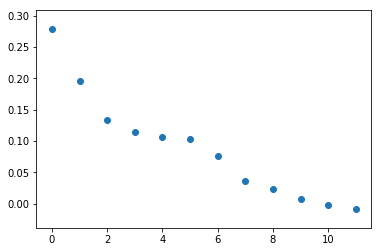

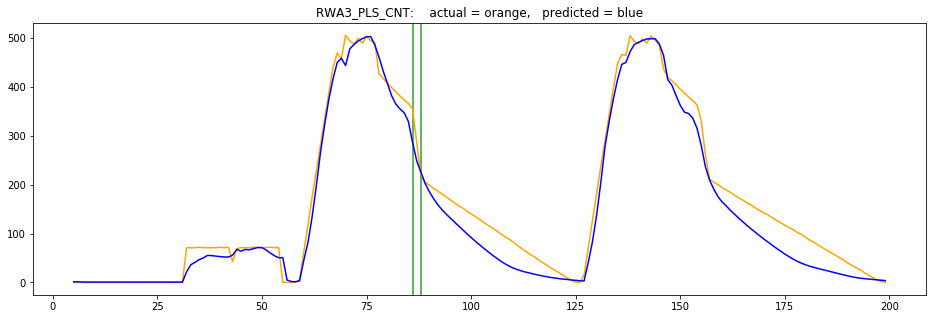

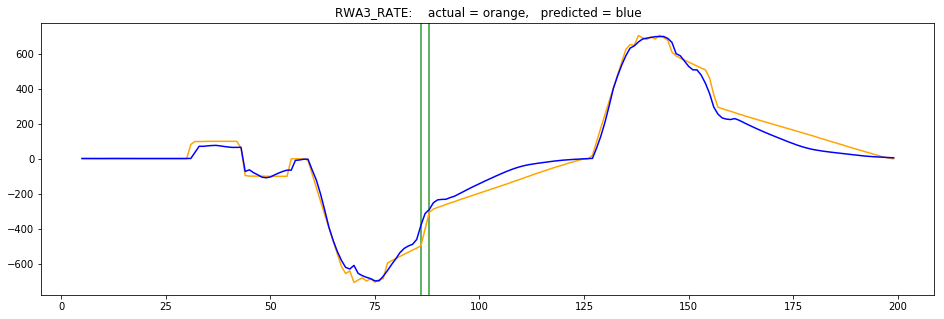

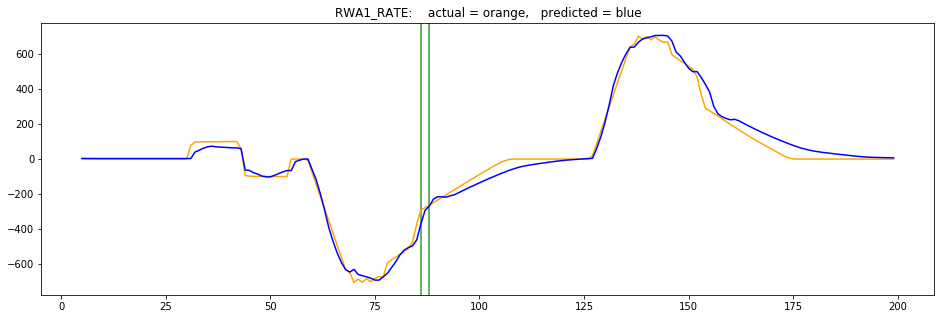

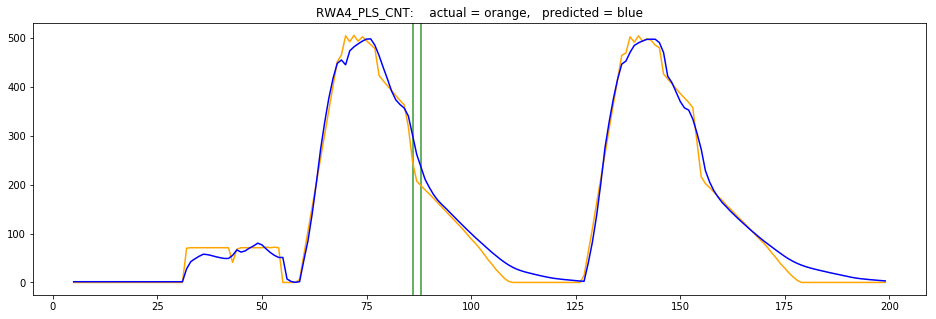

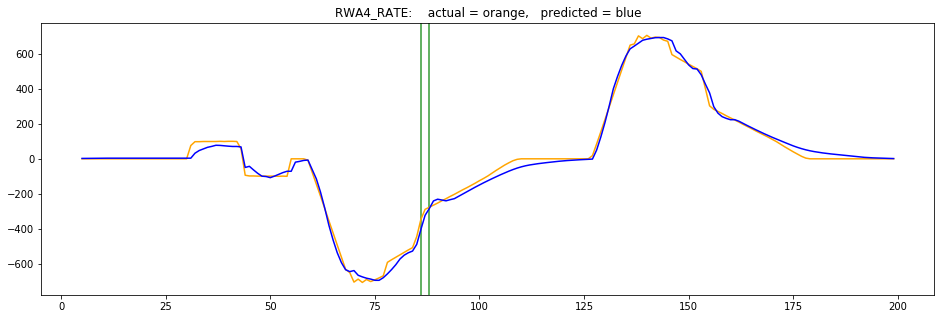

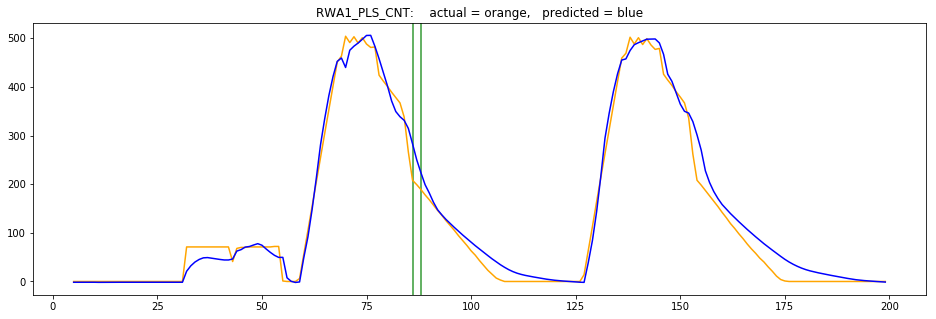

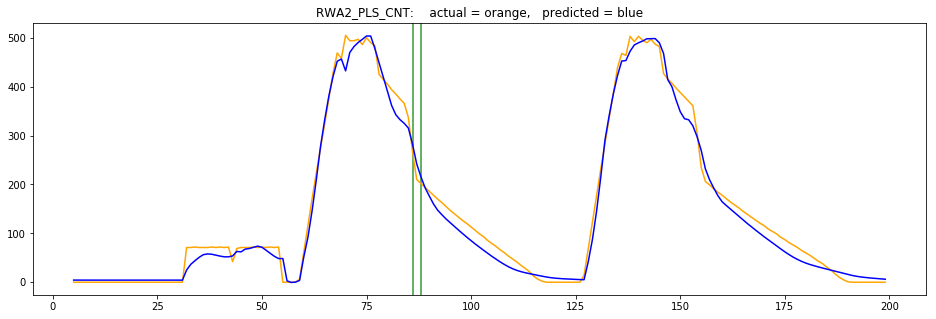

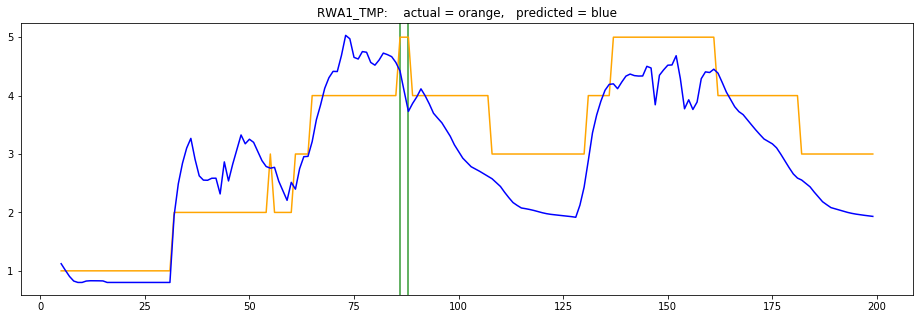

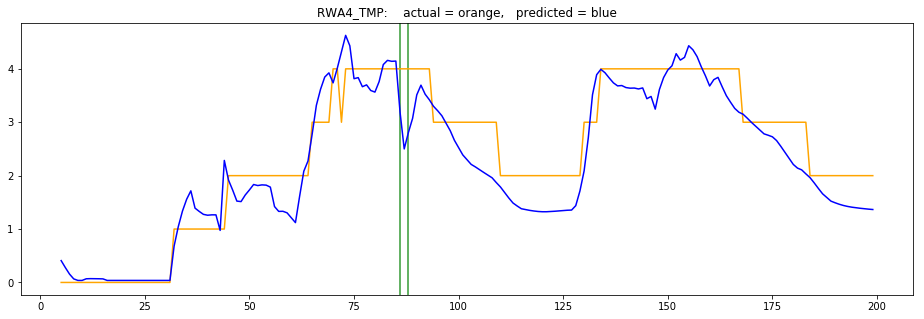

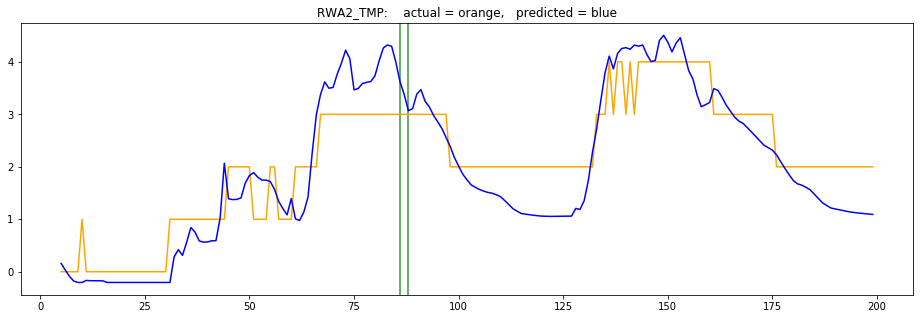

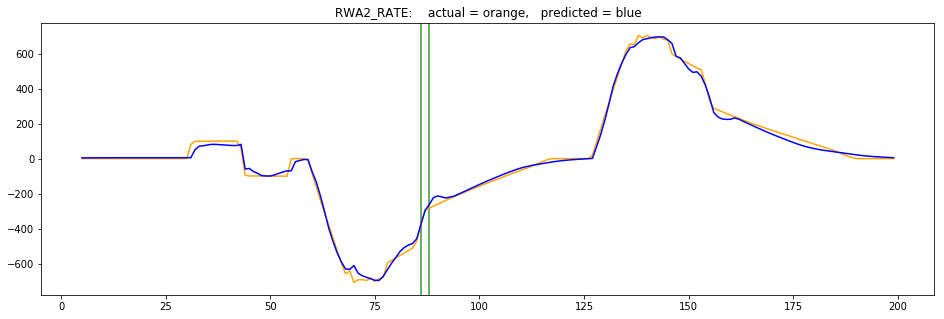

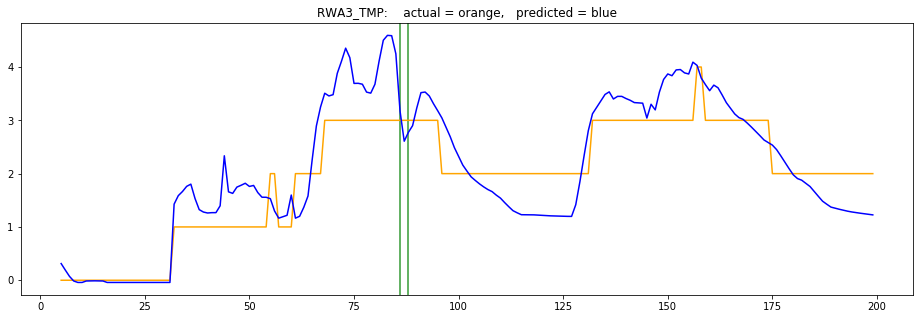

In [122]:
# Does it see the slow wheel in SV1C1?  Not as well as with S1C4.
importlib.reload(lstm_ui_tools_mult_train)
score, r2score, raw_preds, scaled_preds, raw_flag, flagged_times = lstm_ui_tools_mult_train.score_model_gps3(model2,
                                            inferencefile=directory+'/GPS3_SV01_small_c1.csv',
                                            r2=-np.inf,
                                            graph_score=False,
                                            rolling_window = 3,
                                            graph_flag = True)

print(flagged_times)


mean_diff = lstm_ui_tools_mult_train.find_newly_broken_gps3(model2, 103, 111)
print(mean_diff)
plt.scatter(list(range(len(mean_diff))),mean_diff)
plt.show()


lstm_ui_tools_mult_train.graph_sensors_gps(model2, sensorlist = mean_diff.index.tolist(), anomstart=86, anomend=88)



# Looking at all inferences against the SV2 model.

In [88]:
files =['/GPS3_SV02_small_h1.csv', '/GPS3_SV02_small_c1.csv', '/GPS3_SV02_small_h4.csv', '/GPS3_SV02_small_c4.csv', '/GPS3_SV01_small_c1.csv', '/GPS3_SV01_small_h4.csv', '/GPS3_SV01_small_c4.csv']
all_flagged_times = []

for test in files:
    for r2 in [-np.inf, 0.1, 0.5, 0.9, 0.99]:
        for rolling_window in [1, 3, 5]:
            print(test, r2, rolling_window)
            score, r2score, raw_preds, scaled_preds, raw_flag, flagged_times = lstm_ui_tools_mult_train.score_model_gps3(model2,
                                                inferencefile=directory+test,
                                                r2=r2,
                                                rolling_window = rolling_window,
                                                graph_score=False)
            print(flagged_times)
            all_flagged_times.append((test, r2, rolling_window, flagged_times))



/GPS3_SV02_small_h1.csv -inf 1
[34, 58, 63, 64, 81, 88, 89, 142, 149]
/GPS3_SV02_small_h1.csv -inf 3
[64, 65, 89, 90]
/GPS3_SV02_small_h1.csv -inf 5
[]
/GPS3_SV02_small_h1.csv 0.1 1
[34, 58, 63, 64, 81, 88, 89, 142, 149]
/GPS3_SV02_small_h1.csv 0.1 3
[64, 65, 89, 90]
/GPS3_SV02_small_h1.csv 0.1 5
[]
/GPS3_SV02_small_h1.csv 0.5 1
[34, 58, 63, 64, 81, 88, 89, 142, 149]
/GPS3_SV02_small_h1.csv 0.5 3
[64, 65, 89, 90]
/GPS3_SV02_small_h1.csv 0.5 5
[]
/GPS3_SV02_small_h1.csv 0.9 1
[34, 58, 63, 64, 81, 88, 89, 142, 149]
/GPS3_SV02_small_h1.csv 0.9 3
[64, 65, 89, 90]
/GPS3_SV02_small_h1.csv 0.9 5
[]
/GPS3_SV02_small_h1.csv 0.99 1
[34, 58, 63, 64, 74, 81, 88, 89, 142, 149]
/GPS3_SV02_small_h1.csv 0.99 3
[64, 65, 89, 90]
/GPS3_SV02_small_h1.csv 0.99 5
[]
/GPS3_SV02_small_c1.csv -inf 1
[29, 52, 56, 57, 58, 66, 73, 81, 127, 142]
/GPS3_SV02_small_c1.csv -inf 3
[57, 58, 59]
/GPS3_SV02_small_c1.csv -inf 5
[58, 59, 60]
/GPS3_SV02_small_c1.csv 0.1 1
[29, 52, 56, 57, 58, 66, 73, 81, 127, 142]
/GPS3_SV02

[32, 33, 44, 45, 46, 47, 55, 56, 61, 62, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 146, 147, 150, 151, 152, 153, 154, 155, 156, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196]
/GPS3_SV01_small_h4.csv 0.1 5
[44, 45, 46, 47, 48, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 153, 154, 155, 156, 157, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,

In [89]:
# with open ('all_flagged_times_mult_SV02_train.txt', 'w') as infile:
#     for line in all_flagged_times:
#         infile.write(str(line)+'\n')


In [92]:
all_flagged_times[1]

('/GPS3_SV02_small_h1.csv', -inf, 3, [64, 65, 89, 90])

In [108]:
for x in all_flagged_times:
    if len(x[3]) <= 200 and len(x[3])>=0 and float(x[1]) >= 0.1:
        print('{}{}, r2 = {}, rolling_window = {}: {}'.format(x[0][9], x[0][17:19], x[1], x[2], len(x[3])))
    if x[2] == 5 and x[1] == 0.99:
        print('')

2h1, r2 = 0.1, rolling_window = 1: 9
2h1, r2 = 0.1, rolling_window = 3: 4
2h1, r2 = 0.1, rolling_window = 5: 0
2h1, r2 = 0.5, rolling_window = 1: 9
2h1, r2 = 0.5, rolling_window = 3: 4
2h1, r2 = 0.5, rolling_window = 5: 0
2h1, r2 = 0.9, rolling_window = 1: 9
2h1, r2 = 0.9, rolling_window = 3: 4
2h1, r2 = 0.9, rolling_window = 5: 0
2h1, r2 = 0.99, rolling_window = 1: 10
2h1, r2 = 0.99, rolling_window = 3: 4
2h1, r2 = 0.99, rolling_window = 5: 0

2c1, r2 = 0.1, rolling_window = 1: 10
2c1, r2 = 0.1, rolling_window = 3: 3
2c1, r2 = 0.1, rolling_window = 5: 3
2c1, r2 = 0.5, rolling_window = 1: 10
2c1, r2 = 0.5, rolling_window = 3: 3
2c1, r2 = 0.5, rolling_window = 5: 3
2c1, r2 = 0.9, rolling_window = 1: 10
2c1, r2 = 0.9, rolling_window = 3: 3
2c1, r2 = 0.9, rolling_window = 5: 3
2c1, r2 = 0.99, rolling_window = 1: 11
2c1, r2 = 0.99, rolling_window = 3: 5
2c1, r2 = 0.99, rolling_window = 5: 3

2h4, r2 = 0.1, rolling_window = 1: 8
2h4, r2 = 0.1, rolling_window = 3: 2
2h4, r2 = 0.1, rolling_wi

In [109]:
all_flagged_times[1]

('/GPS3_SV02_small_h1.csv', -inf, 3, [64, 65, 89, 90])

In [120]:
for x in all_flagged_times:
    if len(x[3]) <= 200 and len(x[3])>=0 and float(x[1]) == 0.1 and x[2] == 3:
        print('{}{}: {},   r2 = {},  rolling_window =  {}'.format(x[0][9], x[0][17:19], len(x[3]), x[1], x[2]))
#     if x[2] == 5 and x[1] == 0.99:
#         print('')

2h1: 4,   r2 = 0.1,  rolling_window =  3
2c1: 3,   r2 = 0.1,  rolling_window =  3
2h4: 2,   r2 = 0.1,  rolling_window =  3
2c4: 5,   r2 = 0.1,  rolling_window =  3
1c1: 33,   r2 = 0.1,  rolling_window =  3
1h4: 115,   r2 = 0.1,  rolling_window =  3
1c4: 18,   r2 = 0.1,  rolling_window =  3


In [121]:
for x in all_flagged_times:
    if len(x[3]) <= 200 and len(x[3])>=0 and float(x[1]) == 0.1 and x[2] == 3:
        print('{}{}: {}'.format(x[0][9], x[0][17:19], len(x[3]), x[1], x[2]))


2h1: 4
2c1: 3
2h4: 2
2c4: 5
1c1: 33
1h4: 115
1c4: 18


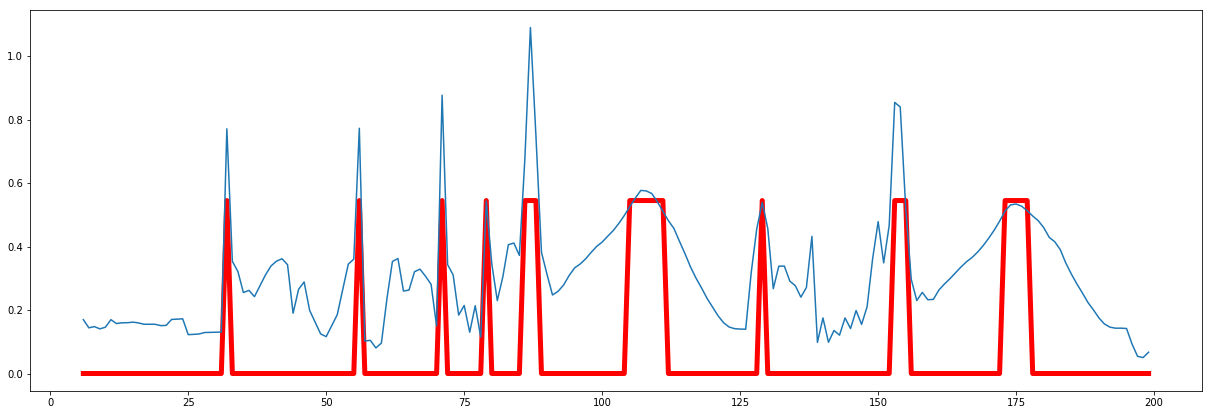

[32, 56, 71, 79, 86, 87, 88, 105, 106, 107, 108, 109, 110, 111, 129, 153, 154, 155, 173, 174, 175, 176, 177]
RWA3_PLS_CNT    0.284148
RWA3_RATE       0.207951
RWA4_PLS_CNT    0.134638
RWA4_RATE       0.122022
RWA1_RATE       0.106559
RWA1_PLS_CNT    0.068613
RWA1_TMP        0.029902
RWA2_TMP        0.013978
RWA4_TMP        0.010543
RWA2_RATE      -0.003258
RWA3_TMP       -0.003974
RWA2_PLS_CNT   -0.006961
dtype: float64


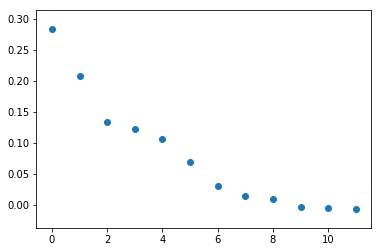

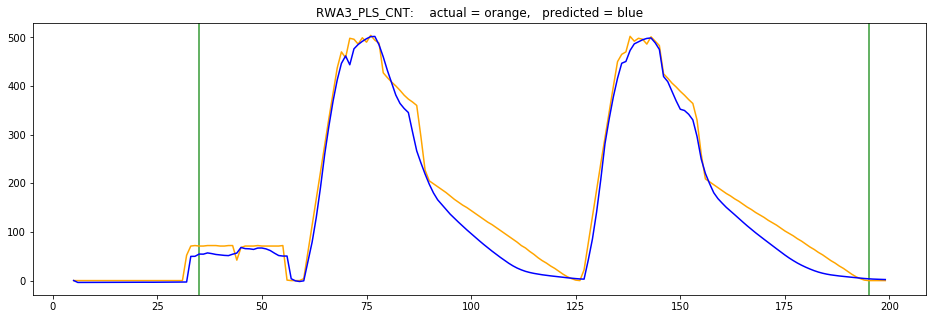

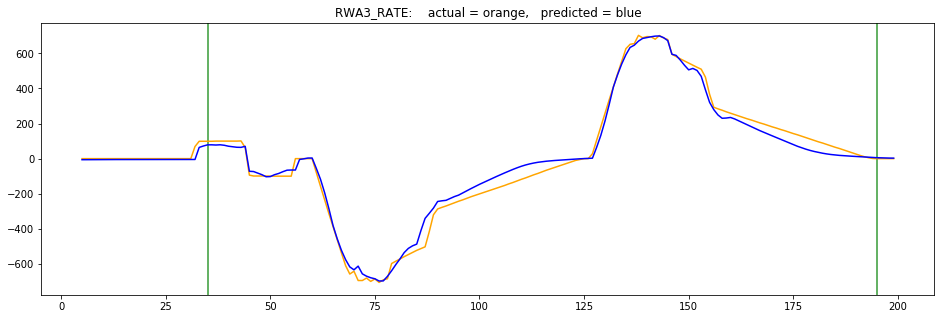

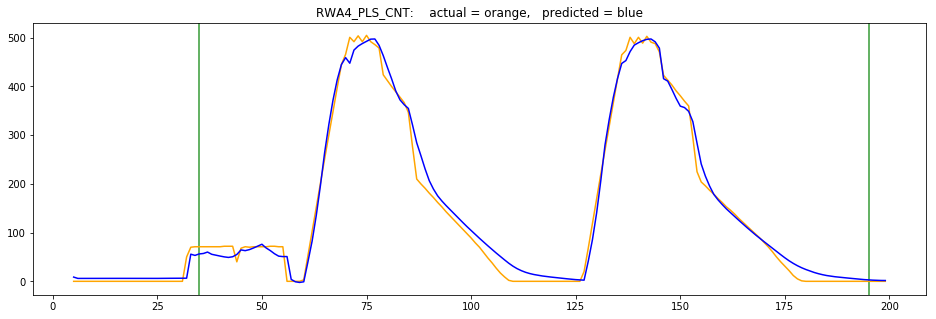

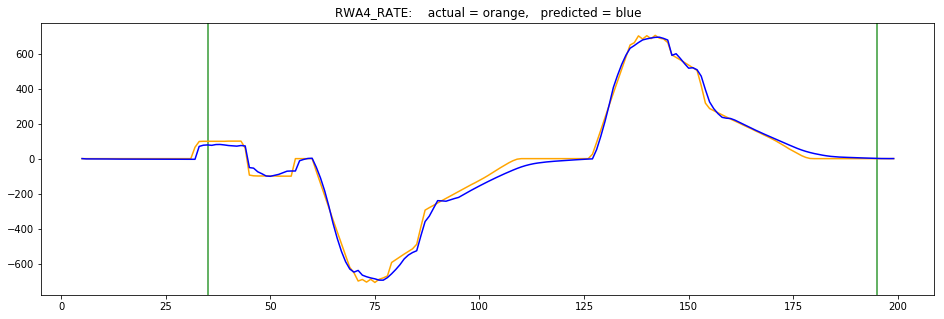

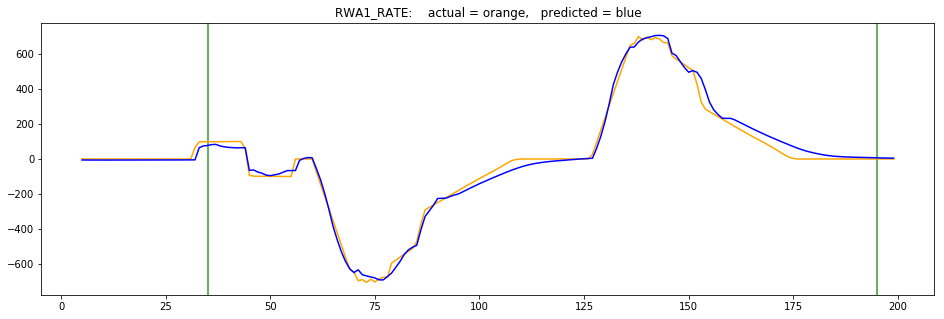

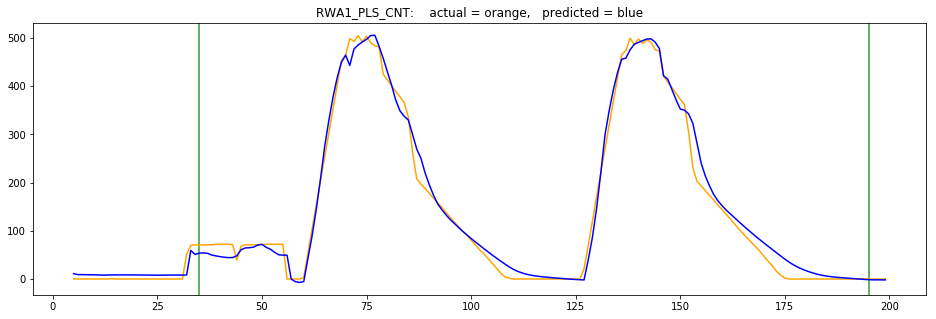

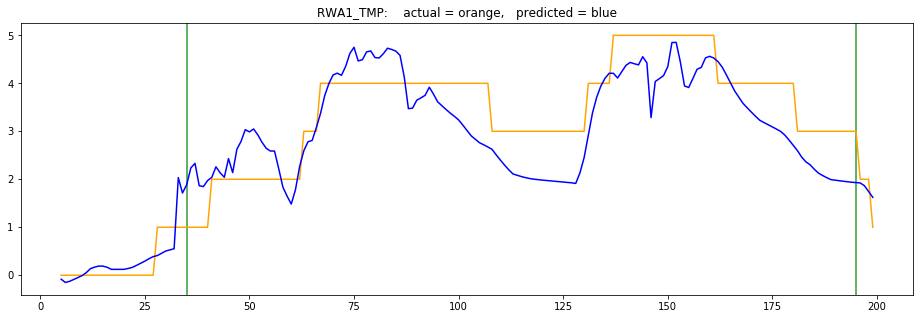

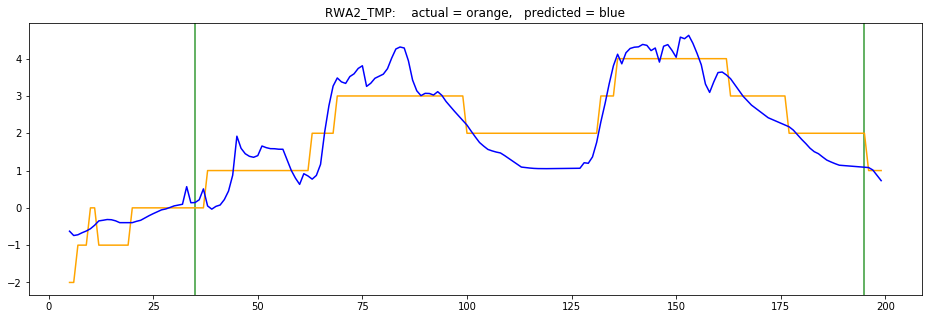

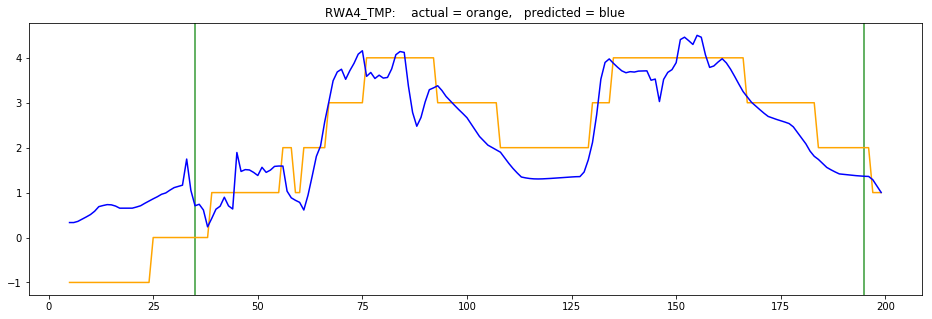

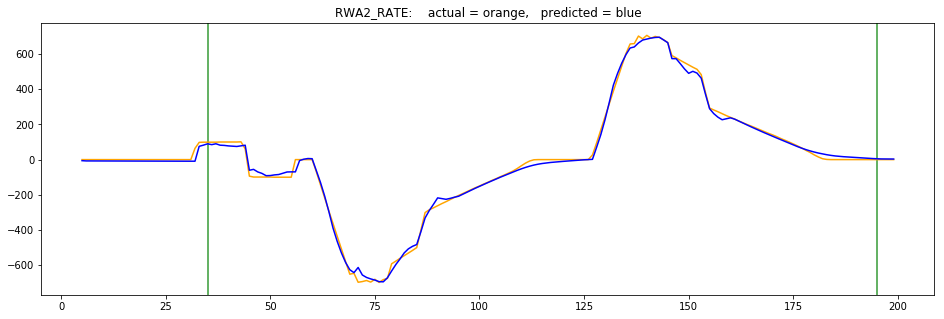

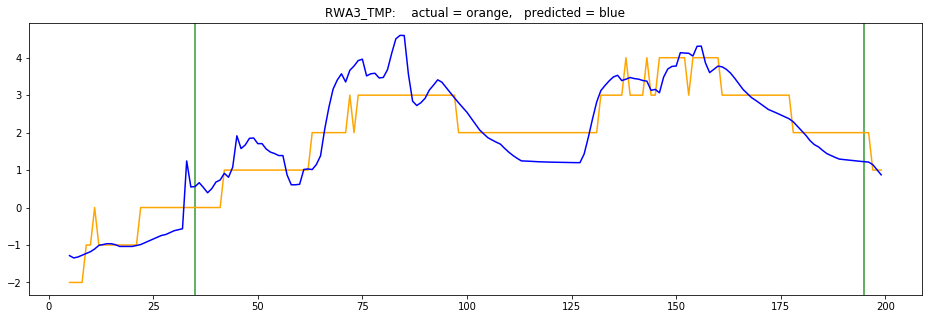

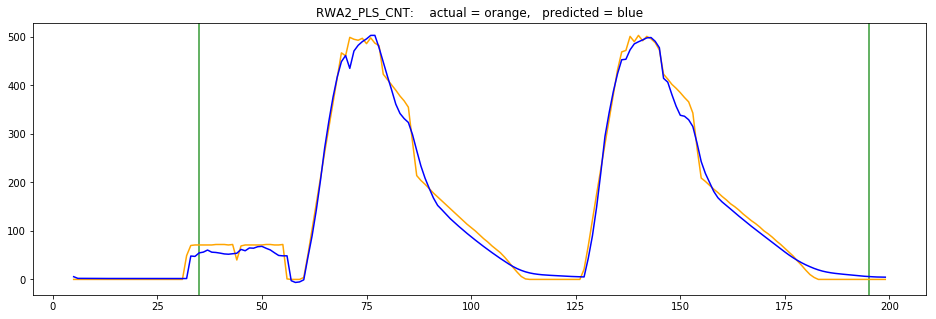

In [50]:
importlib.reload(lstm_ui_tools_mult_train)
score, r2score, raw_preds, scaled_preds, raw_flag, flagged_times = lstm_ui_tools_mult_train.score_model_gps3(model2,
                                            inferencefile=directory+'/GPS3_SV01_small_c4.csv',
                                            r2=0.2,
                                            graph_score=False,
                                            graph_flag = True)

print(flagged_times)


mean_diff = lstm_ui_tools_mult_train.find_newly_broken_gps3(model2, 105, 111)
print(mean_diff)
plt.scatter(list(range(len(mean_diff))),mean_diff)
plt.show()


lstm_ui_tools_mult_train.graph_sensors_gps(model2, sensorlist = mean_diff.index.tolist(), anomstart=35, anomend=195)



In [ ]:
for sensor in raw_preds.columns:
    f, (ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
    ax1.plot(scaled_preds[sensor])
    ax2.plot(raw_preds[sensor])
    ax1.set_title('SCALED {}'.format(sensor))
    ax2.set_title('RAW {}'.format(sensor))
    plt.show()

In [17]:
len(model2.train_raw[0])

200

In [23]:
len(model2.validate_y[0])

195

In [21]:
model2.test_y.shape

(195, 12)

In [24]:
type(model2.validate_y[0])

numpy.ndarray

In [26]:
type(model2.validate_abs_errordflist[0])

pandas.core.frame.DataFrame

In [27]:
model2.validate_abs_errordflist[0].shape

(195, 12)

In [ ]:
print(raw_preds.shape)
raw_preds.head()

In [ ]:
print(scaled_preds.shape)
scaled_preds.head()

In [ ]:
for sensor in raw_preds.columns:
    f, (ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
    ax1.plot(scaled_preds[sensor])
    ax2.plot(raw_preds[sensor])
    ax1.set_title('SCALED {}'.format(sensor))
    ax2.set_title('RAW {}'.format(sensor))
    plt.show()

In [ ]:
fulltestdf = pd.read_csv(directory+'/GPS3_SV02_small_h4.csv', low_memory=False)

In [ ]:
testdf = fulltestdf.iloc[:6]
score, r2score, raw_preds, scaled_preds, raw_flag, flagged_times = lstm_ui_tools.score_model_gps3(model2h1,
                                            inferencedata=testdf,
                                            r2=0.1,
                                            graph_score=False,
                                            graph_flag = False)
print(preds.shape)
raw_preds.head()

In [ ]:
importlib.reload(lstm_ui_tools)
testdf = fulltestdf.iloc[10:20]
score, r2score, raw_preds, scaled_preds, raw_flag, flagged_times = lstm_ui_tools.score_model_gps3(model2h1,
                                            inferencedata=testdf,
                                            r2=0.1,
                                            graph_score=False,
                                            graph_flag = False)
print(raw_preds.shape)
raw_preds.head()

In [ ]:
raw_flag

In [ ]:
flagged_times